In [ ]:
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import os
drive.mount('/content/drive')
print('현재 경로: ',os.getcwd())

Mounted at /content/drive
현재 경로:  /content


In [ ]:
import pandas as pd

# CSV 파일 경로 지정
file_path = '/content/drive/MyDrive/BOAZ_미니프로젝트1/Code정리/ml-1m/1M_movie_data.csv'

# CSV 파일 읽기
df = pd.read_csv(file_path)

# 데이터 확인
print(df.head())

In [ ]:
df["사용자ID"].nunique()

4431

In [ ]:
targeted=df[['영화ID','keywords']].sort_values('영화ID',ascending=True)

In [ ]:
targeted[targeted['영화ID']==1]["keywords"]

# 모든 행의 마지막 열 값이 같은지 검사
first_value = targeted["keywords"].iloc[0]
all_same = all(value == first_value for value in targeted[targeted['영화ID']==1]["keywords"])

# 결과 출력
print("모든 행의 마지막 열 값이 동일한가?", all_same)

# different_values = targeted[targeted["keywords"] != first_value]

모든 행의 마지막 열 값이 동일한가? True


In [ ]:
df[["영화ID","overview"]]

,영화ID,overview
0,1193,While serving time for insanity at a state men...
1,3408,A twice-divorced mother of three who sees an i...
2,1287,Ben-Hur is a 1959 epic film directed by Willia...
3,594,"A beautiful girl, Snow White, takes refuge in ..."
4,595,The story of a gentle-hearted beast in love wi...
...,...,...
356626,2028,"As U.S. troops storm the beaches of Normandy, ..."
356627,1089,A botched robbery indicates a police informant...
356628,1090,"As a young and naive recruit in Vietnam, Chris..."
356629,1091,Two friends are invited for a weekend to a lux...


In [ ]:
df2=df.copy()

In [ ]:
df2=df2[['사용자ID','영화ID','평점','타임스탬프']]

In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df.sort_values(by=['사용자ID', '영화ID'], inplace=True)

### **Matrix Factorization+Multi Layer Perceptron**



*   여기까지는 GMF가 아닌, MF+MLP과정을 통해 embedding생성함



Epoch 1/10, Train Loss: 0.7605
Epoch 1/10, Validation Loss: 0.7291
Epoch 2/10, Train Loss: 0.6909
Epoch 2/10, Validation Loss: 0.7207
Epoch 3/10, Train Loss: 0.6839
Epoch 3/10, Validation Loss: 0.7207
Epoch 4/10, Train Loss: 0.6729
Epoch 4/10, Validation Loss: 0.7056
Epoch 5/10, Train Loss: 0.6659
Epoch 5/10, Validation Loss: 0.7030
Epoch 6/10, Train Loss: 0.6614
Epoch 6/10, Validation Loss: 0.6976
Epoch 7/10, Train Loss: 0.6591
Epoch 7/10, Validation Loss: 0.6965
Epoch 8/10, Train Loss: 0.6573
Epoch 8/10, Validation Loss: 0.7027
Epoch 9/10, Train Loss: 0.6562
Epoch 9/10, Validation Loss: 0.6979
Epoch 10/10, Train Loss: 0.6543
Epoch 10/10, Validation Loss: 0.6954


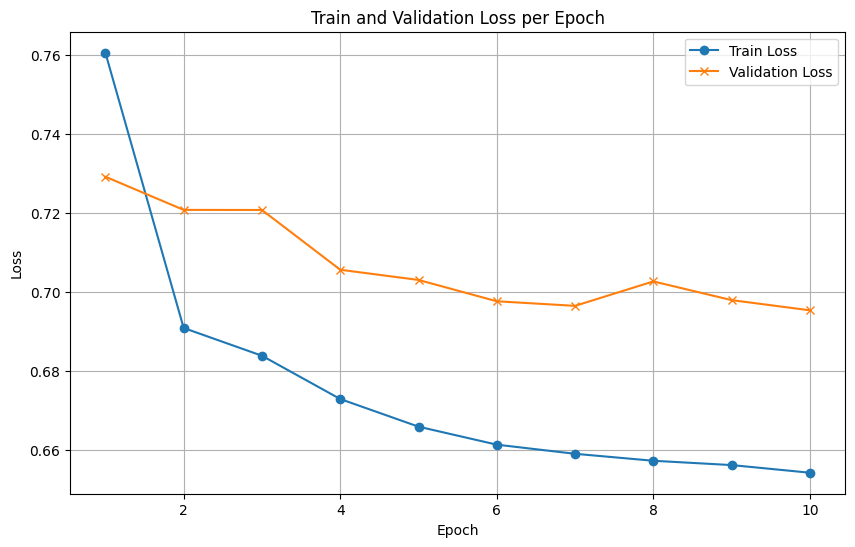

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import copy
import matplotlib.pyplot as plt

# Step 1: 데이터 준비
ratings_df = df2  # 사용자 데이터를 사용

# Step 2: 사용자 및 영화 ID 매핑
user_map = {user_id: idx for idx, user_id in enumerate(ratings_df['사용자ID'].unique())}
movie_map = {movie_id: idx for idx, movie_id in enumerate(ratings_df['영화ID'].unique())}

# 역매핑 (결과를 원래 ID로 변환하기 위해 필요)
reverse_user_map = {v: k for k, v in user_map.items()}
reverse_movie_map = {v: k for k, v in movie_map.items()}

# 사용자와 영화 ID를 매핑된 값으로 변환
ratings_df['user_idx'] = ratings_df['사용자ID'].map(user_map)
ratings_df['movie_idx'] = ratings_df['영화ID'].map(movie_map)

# Step 3: 사용자별 Train/Validation 데이터 분할 (최신 타임스탬프 기준)
train_list = []
validation_list = []

for user_id, group in ratings_df.groupby('user_idx'):
    group = group.sort_values('타임스탬프')  # 타임스탬프 기준으로 정렬
    split_idx = int(len(group) * 0.8)  # 80% 지점에서 분할
    train_list.append(group.iloc[:split_idx])
    validation_list.append(group.iloc[split_idx:])

train_data = pd.concat(train_list).reset_index(drop=True)
validation_data = pd.concat(validation_list).reset_index(drop=True)

# PyTorch 텐서로 변환 (Train 데이터)
train_user_ids = torch.tensor(train_data['user_idx'].values, dtype=torch.long)
train_item_ids = torch.tensor(train_data['movie_idx'].values, dtype=torch.long)
train_ratings = torch.tensor(train_data['평점'].values, dtype=torch.float32)

# Step 4: 모델 정의 및 학습
class MF_MLP(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=15, mlp_hidden_layers=[16,16,8]):
        super(MF_MLP, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        self.gmf_layer = nn.Linear(embedding_dim, 1)
        mlp_layers = []
        input_dim = embedding_dim * 2
        for hidden_dim in mlp_hidden_layers:
            mlp_layers.append(nn.Linear(input_dim, hidden_dim))
            mlp_layers.append(nn.ReLU())
            input_dim = hidden_dim
        self.mlp = nn.Sequential(*mlp_layers)
        self.final_layer = nn.Linear(mlp_hidden_layers[-1] + 1, 1)

    def forward(self, user_ids, item_ids):
        user_embeds = self.user_embedding(user_ids)
        item_embeds = self.item_embedding(item_ids)
        gmf_output = user_embeds * item_embeds
        gmf_output = self.gmf_layer(gmf_output)
        mlp_input = torch.cat([user_embeds, item_embeds], dim=-1)
        mlp_output = self.mlp(mlp_input)
        combined_input = torch.cat([gmf_output, mlp_output], dim=-1)
        output = self.final_layer(combined_input).squeeze()
        output = (torch.tanh(output) + 1) * 2 + 1  # 1 ~ 5로 변환
        return output

# 사용자와 영화 개수에 맞게 모델 초기화
num_users = len(user_map)
num_items = len(movie_map)
model = MF_MLP(num_users, num_items, embedding_dim=15)

# 손실 함수 및 옵티마이저 설정
criterion = lambda predictions, targets: torch.mean(torch.abs(predictions - targets))  # MAD (Mean Absolute Deviation)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Early Stopping 및 Best Model 저장 변수 설정
best_validation_loss = float('inf')
patience = 10
patience_counter = 0
best_model_state = None

# 배치 데이터 생성
train_dataset = TensorDataset(train_user_ids, train_item_ids, train_ratings)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 모델 학습 및 손실 기록
train_losses = []
validation_losses = []

epochs = 100
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for batch_user_ids, batch_item_ids, batch_ratings in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_user_ids, batch_item_ids)
        loss = criterion(predictions, batch_ratings)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}")

    # 검증 단계
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        validation_user_ids = torch.tensor(validation_data['user_idx'].values, dtype=torch.long)
        validation_item_ids = torch.tensor(validation_data['movie_idx'].values, dtype=torch.long)
        validation_ratings = torch.tensor(validation_data['평점'].values, dtype=torch.float32)
        validation_predictions = model(validation_user_ids, validation_item_ids)
        validation_loss = criterion(validation_predictions, validation_ratings).item()
    validation_losses.append(validation_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {validation_loss:.4f}")

    # Best Model 저장 및 Early Stopping 조건 검사
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        patience_counter = 0  # 개선이 되면 카운터 초기화
        best_model_state = copy.deepcopy(model.state_dict())  # Best Model 저장
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Best Model 로드
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# 손실 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Step 6: 추천 예시 (원래 ID로 변환)
top_k = 20

recommendations_all = []
model.eval()

# 모든 사용자에 대해 반복
for user in user_map.values():
    # 해당 사용자의 모든 영화에 대한 예측값 계산
    user_tensor = torch.tensor([user])
    all_movies_tensor = torch.tensor(list(range(num_items)))
    predictions = model(user_tensor.expand_as(all_movies_tensor), all_movies_tensor)

    # 이미 평가한 영화 인덱스 가져오기 (Train 데이터 기준)
    rated_movies = set(train_data[train_data['user_idx'] == user]['movie_idx'].values)

    # 평가하지 않은 영화에 대해서만 예측값과 영화 인덱스를 튜플로 저장
    unrated_predictions = [
        (movie_idx, rating.item())
        for movie_idx, rating in enumerate(predictions)
        if movie_idx not in rated_movies
    ]

    # 예측 평점이 높은 순으로 정렬
    unrated_predictions.sort(key=lambda x: x[1], reverse=True)

    # 상위 20개 추천 영화 선택
    top_20 = unrated_predictions[:20]

    # 각 추천에 대해 원래 사용자ID, 영화ID와 예상 평점을 저장
    for movie_idx, rating in top_20:
        original_user_id = reverse_user_map[user]
        original_movie_id = reverse_movie_map[movie_idx]
        recommendations_all.append({
            '사용자ID': original_user_id,
            '추천영화ID': original_movie_id,
            '예상평점': rating
        })

# DataFrame으로 변환 후 CSV 파일로 저장
recommendations_dfdf = pd.DataFrame(recommendations_all)
recommendations_dfdf.to_csv("user_recommendations.csv", index=False)

In [ ]:
test_user_id = torch.tensor([user_map[1]])  #사용자 1에 대한 추천 예측
test_movie_ids = torch.tensor(list(range(num_items)))  # 모든 영화에 대해 예측
predicted_ratings = model(test_user_id.expand_as(test_movie_ids), test_movie_ids)

In [ ]:
predicted_ratings #이렇게 user_id 1인 사람의 모든 영화_id에 대응되는 예측 평점을 도출할 수 있게됨

### **Main 제안코드**

***Recommendation with GMF+MLP=NCF***


*   Matrix Factorization 에서 비선형성(제안 코드에서는 sigmoid)을 추가한 GMF
*   위 과정을 도출된 item embedding 및 user embedding값을 concatenate한 후 이용하여 Multi Perceptron로 DNN기반의 학습 진행
  *    이를 통해 target 평점을 예측함


Epoch 1/20, Train Loss: 0.7317
Epoch 1/20, Validation Loss: 0.7291
Epoch 2/20, Train Loss: 0.6963
Epoch 2/20, Validation Loss: 0.7216
Epoch 3/20, Train Loss: 0.6838
Epoch 3/20, Validation Loss: 0.7166
Epoch 4/20, Train Loss: 0.6750
Epoch 4/20, Validation Loss: 0.7023
Epoch 5/20, Train Loss: 0.6651
Epoch 5/20, Validation Loss: 0.6999
Epoch 6/20, Train Loss: 0.6599
Epoch 6/20, Validation Loss: 0.6963
Epoch 7/20, Train Loss: 0.6560
Epoch 7/20, Validation Loss: 0.6966
Epoch 8/20, Train Loss: 0.6535
Epoch 8/20, Validation Loss: 0.6963
Epoch 9/20, Train Loss: 0.6513
Epoch 9/20, Validation Loss: 0.6934
Epoch 10/20, Train Loss: 0.6492
Epoch 10/20, Validation Loss: 0.6965
Epoch 11/20, Train Loss: 0.6489
Epoch 11/20, Validation Loss: 0.6968
Epoch 12/20, Train Loss: 0.6485
Epoch 12/20, Validation Loss: 0.6958
Epoch 13/20, Train Loss: 0.6473
Epoch 13/20, Validation Loss: 0.6947
Epoch 14/20, Train Loss: 0.6472
Epoch 14/20, Validation Loss: 0.6942
Epoch 15/20, Train Loss: 0.6468
Epoch 15/20, Validat

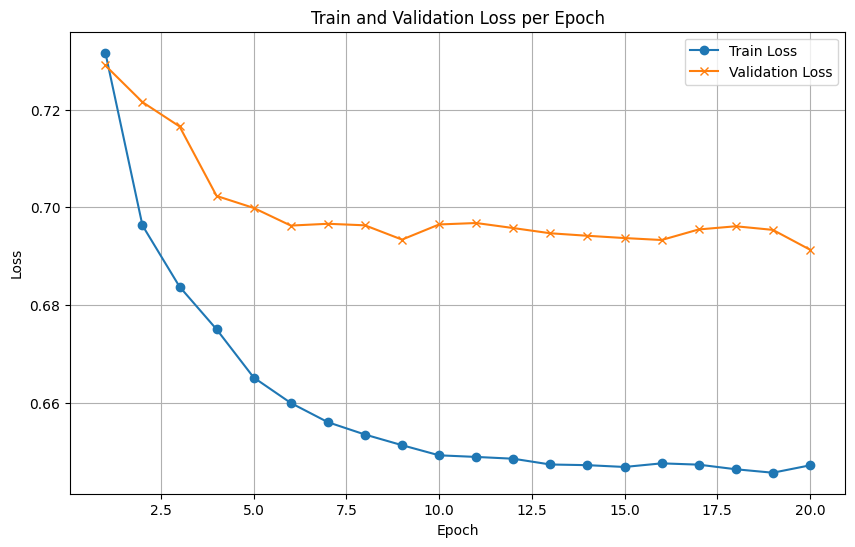

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import copy
import matplotlib.pyplot as plt

# Step 1: 데이터 준비
ratings_df = df2  # 사용자 데이터를 사용

# Step 2: 사용자 및 영화 ID 매핑
user_map = {user_id: idx for idx, user_id in enumerate(ratings_df['사용자ID'].unique())}
movie_map = {movie_id: idx for idx, movie_id in enumerate(ratings_df['영화ID'].unique())}

# 역매핑 (결과를 원래 ID로 변환하기 위해 필요)
reverse_user_map = {v: k for k, v in user_map.items()}
reverse_movie_map = {v: k for k, v in movie_map.items()}

# 사용자와 영화 ID를 매핑된 값으로 변환
ratings_df['user_idx'] = ratings_df['사용자ID'].map(user_map)
ratings_df['movie_idx'] = ratings_df['영화ID'].map(movie_map)

# Step 3: 사용자별 Train/Validation 데이터 분할 (최신 타임스탬프 기준)
train_list = []
validation_list = []

for user_id, group in ratings_df.groupby('user_idx'):
    group = group.sort_values('타임스탬프')  # 타임스탬프 기준으로 정렬
    split_idx = int(len(group) * 0.8)  # 80% 지점에서 분할
    train_list.append(group.iloc[:split_idx])
    validation_list.append(group.iloc[split_idx:])

train_data = pd.concat(train_list).reset_index(drop=True)
validation_data = pd.concat(validation_list).reset_index(drop=True)

# PyTorch 텐서로 변환 (Train 데이터)
train_user_ids = torch.tensor(train_data['user_idx'].values, dtype=torch.long)
train_item_ids = torch.tensor(train_data['movie_idx'].values, dtype=torch.long)
train_ratings = torch.tensor(train_data['평점'].values, dtype=torch.float32)

# PyTorch 텐서로 변환 (Validation 데이터)
validation_user_ids = torch.tensor(validation_data['user_idx'].values, dtype=torch.long)
validation_item_ids = torch.tensor(validation_data['movie_idx'].values, dtype=torch.long)
validation_ratings = torch.tensor(validation_data['평점'].values, dtype=torch.float32)

# Validation DataLoader 생성
validation_dataset = TensorDataset(validation_user_ids, validation_item_ids, validation_ratings)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

import torch
import torch.nn as nn

#NCF model
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=16, mlp_hidden_layers=[32, 16, 8]):
        super(NCF, self).__init__()
        # Embedding Layers
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        # MLP Layers
        mlp_layers = []
        input_dim = embedding_dim * 2
        for hidden_dim in mlp_hidden_layers:
            mlp_layers.append(nn.Linear(input_dim, hidden_dim))
            mlp_layers.append(nn.ReLU())
            input_dim = hidden_dim
        self.mlp = nn.Sequential(*mlp_layers)

        # Final output layer combining GMF and MLP
        self.final_layer = nn.Linear(mlp_hidden_layers[-1] + embedding_dim, 1)  # embedding_dim 추가

        # Output Activation Function
        self.output_activation = nn.Sigmoid()

        # Initialize Embeddings
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)

    def forward(self, user_ids, item_ids):
        # Embedding Lookups
        user_embeds = self.user_embedding(user_ids)
        item_embeds = self.item_embedding(item_ids)

        # GMF Output (Element-wise Multiplication)
        gmf_output = user_embeds * item_embeds  # GMF는 단순 element-wise 곱셈

        # MLP Output
        mlp_input = torch.cat([user_embeds, item_embeds], dim=-1)
        mlp_output = self.mlp(mlp_input)

        # Combine GMF and MLP Outputs
        combined_input = torch.cat([gmf_output, mlp_output], dim=-1)
        output = self.final_layer(combined_input).squeeze()

        # Apply Sigmoid Activation and Scale to 1~5
        output = self.output_activation(output) * 4 + 1  # Sigmoid output scaled to [1, 5]

        return output


# 사용자와 영화 개수에 맞게 모델 초기화
num_users = len(user_map)
num_items = len(movie_map)
model2 = NCF(num_users, num_items, embedding_dim=16)

# 손실 함수 및 옵티마이저 설정
criterion = lambda predictions, targets: torch.mean(torch.abs(predictions - targets))  # MAD (Mean Absolute Deviation)
optimizer = optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-4)

# Early Stopping 및 Best Model 저장 변수 설정
best_validation_loss = float('inf')
patience = 10
patience_counter = 0
best_model_state = None

# 배치 데이터 생성
train_dataset = TensorDataset(train_user_ids, train_item_ids, train_ratings)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 손실 기록용 리스트 생성
train_losses = []
validation_losses = []

# 모델 학습
epochs = 20
for epoch in range(epochs):
    model2.train()
    epoch_loss = 0.0
    for batch_user_ids, batch_item_ids, batch_ratings in train_loader:
        optimizer.zero_grad()
        predictions = model2(batch_user_ids, batch_item_ids)
        loss = criterion(predictions, batch_ratings)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}")

    # 검증 단계
    model2.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for batch_user_ids, batch_item_ids, batch_ratings in validation_loader:
            batch_predictions = model2(batch_user_ids, batch_item_ids)
            batch_loss = criterion(batch_predictions, batch_ratings)
            validation_loss += batch_loss.item()

    avg_validation_loss = validation_loss / len(validation_loader)
    validation_losses.append(avg_validation_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {avg_validation_loss:.4f}")

    # Best Model 저장 및 Early Stopping 조건 검사
    if avg_validation_loss < best_validation_loss:
        best_validation_loss = avg_validation_loss
        patience_counter = 0  # 개선이 되면 카운터 초기화
        best_model_state = copy.deepcopy(model2.state_dict())  # Best Model 저장
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Best Model 로드
if best_model_state is not None:
    model2.load_state_dict(best_model_state)

# 손실 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Step 6: 각 사용자별로 Top 20 추천 영화 추출

top_k = 20
model2.eval()

all_movie_ids = torch.tensor(list(range(num_items)), dtype=torch.long)

# 모든 사용자에 대해 추천 영화 추출
recommendations_per_user = {}

for user_id in range(num_users):
    user_tensor = torch.tensor([user_id], dtype=torch.long)
    with torch.no_grad():
        predicted_ratings = model2(user_tensor.expand_as(all_movie_ids), all_movie_ids)

    # 이미 평가한 영화도 포함 (필터링 제거)
    recommended_movies = [(idx, rating.item()) for idx, rating in enumerate(predicted_ratings)]

    # 평점이 높은 순으로 정렬하여 Top 20 영화 추출
    recommended_movies.sort(key=lambda x: x[1], reverse=True)
    top_movies = [reverse_movie_map[movie_idx] for movie_idx, _ in recommended_movies[:top_k]]
    recommendations_per_user[reverse_user_map[user_id]] = top_movies

In [ ]:
# DataFrame 생성
recommendations_df = pd.DataFrame.from_dict(recommendations_per_user, orient='index')
recommendations_df.index.name = 'user_id'
recommendations_df.columns = [f'rank_{i+1}' for i in range(top_k)]

In [ ]:
recommendations_df.reset_index(inplace=True)

In [ ]:
# CSV 파일 경로 지정
file_path1 = '/content/drive/MyDrive/BOAZ_미니프로젝트1/확인용/sampling_user.csv'

# CSV 파일 읽기
sample_userdf = pd.read_csv(file_path1)

In [ ]:
target_ids=sample_userdf["사용자ID"].values

In [ ]:
recommendations_df[recommendations_df["user_id"].isin(target_ids)].to_csv("홍준기_final_recommendation_list(NCF)_0215.csv")

In [ ]:
final_df=recommendations_df[recommendations_df["user_id"].isin(target_ids)]
final_df

,user_id,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,...,rank_11,rank_12,rank_13,rank_14,rank_15,rank_16,rank_17,rank_18,rank_19,rank_20
9,15,527,1198,750,2858,1204,1207,1193,912,953,...,904,923,296,608,1136,2028,541,2329,903,3578
10,17,527,1198,750,2858,1204,1207,1193,953,912,...,904,923,1136,608,296,541,2028,903,3307,2959
12,19,527,1198,2858,750,1204,1207,1193,953,912,...,608,1136,904,2329,1208,3578,923,541,899,2028
13,22,527,1198,2858,750,1204,1193,1207,953,912,...,904,923,1136,608,296,541,2329,1208,3307,3578
22,33,527,1198,2858,750,1204,1207,1193,912,953,...,904,923,2028,608,2329,1208,296,1136,1219,903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4412,6016,527,1198,2858,750,1204,1207,1252,953,1214,...,1256,3435,903,2329,1193,1283,1259,1208,924,912
4416,6021,527,1198,750,2858,1204,1193,1207,912,953,...,904,923,1136,296,541,608,2028,2329,2959,903
4418,6023,527,1198,750,2858,1204,1207,1193,953,912,...,904,923,1136,608,296,541,2028,903,2329,2959
4427,6036,527,1198,750,2858,1204,1207,1193,953,912,...,904,923,296,1136,608,541,2028,903,3307,2959
